### Импорт сторонних библиотек

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,  cross_validate, cross_val_score, GridSearchCV
from sklearn.model_selection import cross_val_score
 
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

### Загрузка и объединение данных 

In [48]:
df_hits = pd.read_csv('ga_hits.csv') # Датафрейм, содержащий целевую переменную event_action
df_sessions = pd.read_csv('ga_sessions.csv') # Датафрейм, содержащий признаки для обучения модели и предсказаний

C:\Users\79292\AppData\Local\Temp\ipykernel_22508\3199243048.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sessions = pd.read_csv('ga_sessions.csv') # Датафрейм, содержащий признаки для обучения модели и предсказаний


In [49]:
# По условию задания необходимо построить модель для бинарной классификации. Данные из колонки целевой переменной необходимо привести в соответствие заданию в бинарный вид.
target_action_list = ['sub_car_claim_click', 'sub_car_claim_submit_click', 
'sub_open_dialog_click', 'sub_custom_question_submit_click', 
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success', 
'sub_car_request_submit_click']

df_hits['event_action'] = np.where(df_hits['event_action'].isin(target_action_list), 1, 0)
df_hits.event_action.value_counts()

event_action
0    15621562
1      104908
Name: count, dtype: int64

In [50]:
# Если за время сессии клиент совершил хотя-бы одно целецое действие, то значение целевой переменной для всей сессии равно 1, иначе 0
df_hits = df_hits[['session_id', 'event_action']].groupby('session_id', as_index=False).agg('max')
df_hits.head()

,session_id,event_action
0,1000009318903347362.1632663668.1632663668,0
1,1000010177899156286.1635013443.1635013443,0
2,1000013386240115915.1635402956.1635402956,0
3,1000017303238376207.1623489300.1623489300,0
4,1000020580299877109.1624943350.1624943350,0


In [51]:
df = pd.merge(left=df_hits, right=df_sessions, on='session_id', how='inner')
df = df.drop(columns=['session_id'])

In [52]:
df0 = df.copy()

In [53]:
df0.head()

,event_action,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,0,232832813.163266,2021-09-26,16:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,NaN,mobile,NaN,Samsung,NaN,412x869,Chrome,Russia,Gelendzhik
1,0,232833013.163501,2021-10-23,21:24:03,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,360x640,Samsung Internet,Russia,Voronezh
2,0,232833760.16354,2021-10-28,09:35:56,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,412x846,Chrome,Russia,Cherkessk
3,0,232834672.162349,2021-06-12,12:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Realme,NaN,360x780,Chrome,Russia,Irkutsk
4,0,232835435.162494,2021-06-29,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,414x736,Safari,Russia,Moscow


### Data preparation

#### Дубликаты

In [54]:
# Удаление признаков, которые не будут подаваться на вход модели.
df0 = df0.drop(columns=['client_id', 'visit_date', 'visit_time', 'visit_number'])

In [55]:
df0.duplicated().value_counts()

True     1319574
False     412692
Name: count, dtype: int64

In [56]:
# Один и тот же клиент может может запускать множество сессий, отличающихся друг от друга только датой, порядковым номером и фактом совершения целевого действия. 
df0 = df0.drop_duplicates()

#### Пропуски

In [57]:
missing_values = ((df0.isna().sum() / len(df0)) * 100).sort_values()
missing_values

event_action                 0.000000
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
utm_source                   0.009450
utm_campaign                10.787706
utm_adcontent               19.093174
device_brand                21.808273
device_os                   50.440765
utm_keyword                 51.017466
device_model                97.698041
dtype: float64

In [58]:
print("Количество пропущенных значений в device_brand:", df0.device_brand.isna().sum())

Количество пропущенных значений в device_brand: 90001


In [59]:
# Любое устройство, имеющее ОС iOS или Macintosh произведено компанией Apple
df0['device_brand'] = np.where((df0['device_os']=='iOS') | (df0['device_os']=='Macintosh'), 'Apple', df0['device_brand'])
df0['device_brand'] = df0.device_brand.fillna('unknown')

In [60]:
df0['utm_medium'] = np.where(df0['utm_medium']=='(not set)', 'banner', df0['utm_medium'])

imp_median = SimpleImputer(strategy='most_frequent')
cols_to_fill = ['utm_source', 'utm_campaign', 'utm_adcontent']
df0[cols_to_fill] = imp_median.fit_transform(df0[cols_to_fill])

In [61]:
# Удаление признаков, имеющих более 50% пропусков.
# Кроме того признак 'device_os' может быть полностью восстановлен по столбцам device_category и device_brand, то есть можно судить о его линейной зависимости от категории и бренда.
# Например десктоп Apple - Macintosh, иной десктоп - Windows (в подавляющем большинстве случаев), телефон Apple - iOS, иной телефон - Android (в подавляющем большинстве случаев).
df0 = df0.drop(columns=['device_os', 'utm_keyword', 'device_model'])

#### Выбросы

##### Device_brand

In [62]:
feat_values = df0['device_brand'].value_counts()
feat_values = feat_values/feat_values.sum() * 100
feat_values

device_brand
Samsung    19.724153
unknown    19.573920
Apple      18.629632
Xiaomi     13.801818
Huawei     11.392515
             ...    
Tesla       0.000242
teXet       0.000242
Wexler      0.000242
Smarteo     0.000242
Maxvi       0.000242
Name: count, Length: 201, dtype: float64

In [63]:
keep_cats = feat_values[feat_values > 1].index
keep_cats

Index(['Samsung', 'unknown', 'Apple', 'Xiaomi', 'Huawei', '(not set)',
       'Realme', 'Vivo', 'OPPO', 'OnePlus', 'Nokia', 'Asus'],
      dtype='object', name='device_brand')

In [64]:
df0['device_brand'] = np.where(df0['device_brand'].isin(keep_cats), df0['device_brand'], 'other')
df0['device_brand'].value_counts()

device_brand
Samsung      81400
unknown      80780
Apple        76883
Xiaomi       56959
Huawei       47016
other        29497
(not set)     9764
Realme        5942
Vivo          5512
OPPO          5077
OnePlus       5019
Nokia         4603
Asus          4240
Name: count, dtype: int64

##### Device_screen_resolution

In [65]:
feat_values = df0['device_screen_resolution'].value_counts()
feat_values = feat_values/feat_values.sum() * 100
feat_values

device_screen_resolution
360x640      5.126099
360x800      4.860283
360x780      4.832660
1920x1080    4.686546
414x896      3.792417
               ...   
523x1058     0.000242
491x1072     0.000242
839x408      0.000242
509x640      0.000242
768x1239     0.000242
Name: count, Length: 4947, dtype: float64

In [66]:
keep_cats = feat_values[feat_values > 0.5].index
keep_cats

Index(['360x640', '360x800', '360x780', '1920x1080', '414x896', '360x760',
       '360x720', '393x851', '375x812', '412x915', '375x667', '393x873',
       '412x892', '1366x768', '1536x864', '390x844', '1440x900', '428x926',
       '412x869', '412x846', '414x736', '360x740', '320x568', '1280x720',
       '384x854', '385x854', '1600x900', '320x694', '320x640', '2560x1440',
       '393x786', '1680x1050', '412x732', '1280x800', '1280x1024', '768x1024',
       '320x712', '360x771', '2000x2000', '320x569', '320x676'],
      dtype='object', name='device_screen_resolution')

In [67]:
df0['device_screen_resolution'] = np.where(df0['device_screen_resolution'].isin(keep_cats), df0['device_screen_resolution'], 'other')
df0['device_screen_resolution'].value_counts()

device_screen_resolution
other        94725
360x640      21155
360x800      20058
360x780      19944
1920x1080    19341
414x896      15651
360x760      14722
360x720      14435
393x851      13786
375x812      12505
412x915      12201
375x667      11431
393x873       9526
412x892       8830
1366x768      8468
1536x864      8360
390x844       8160
1440x900      6905
428x926       6064
412x869       6049
412x846       5642
414x736       5480
360x740       5210
320x568       4671
1280x720      4654
384x854       4583
385x854       4091
1600x900      3891
320x694       3855
320x640       3766
2560x1440     3694
393x786       3280
1680x1050     3202
412x732       3162
1280x800      2927
1280x1024     2924
768x1024      2843
320x712       2611
360x771       2592
2000x2000     2558
320x569       2394
320x676       2346
Name: count, dtype: int64

##### Device_browser

In [68]:
feat_values = df0['device_browser'].value_counts()
feat_values = feat_values/feat_values.sum() * 100
feat_values

device_browser
Chrome                              56.841664
Safari                              14.091865
YaBrowser                           10.799822
Android Webview                      5.542148
Samsung Internet                     3.827552
Opera                                2.767439
Safari (in-app)                      2.616721
Firefox                              1.879852
Edge                                 1.329078
UC Browser                           0.128183
Android Runtime                      0.035377
Mozilla Compatible Agent             0.020112
[FBAN                                0.017689
MRCHROME                             0.015993
Instagram 208.0.0.32.135 Android     0.009692
Puffin                               0.009208
Android Browser                      0.008481
Instagram 209.0.0.21.119 Android     0.007269
Internet Explorer                    0.005815
Opera Mini                           0.004846
Maxthon                              0.004604
Android            

In [69]:
keep_cats = feat_values[feat_values > 1].index
keep_cats

Index(['Chrome', 'Safari', 'YaBrowser', 'Android Webview', 'Samsung Internet',
       'Opera', 'Safari (in-app)', 'Firefox', 'Edge'],
      dtype='object', name='device_browser')

In [70]:
df0['device_browser'] = np.where(df0['device_browser'].isin(keep_cats), df0['device_browser'], 'other')
df0['device_browser'].value_counts()

device_browser
Chrome              234581
Safari               58156
YaBrowser            44570
Android Webview      22872
Samsung Internet     15796
Opera                11421
Safari (in-app)      10799
Firefox               7758
Edge                  5485
other                 1254
Name: count, dtype: int64

##### geo_city

In [71]:
feat_values = df0['geo_city'].value_counts()
feat_values = feat_values/feat_values.sum() * 100
feat_values

geo_city
Moscow              21.646894
Saint Petersburg    11.557530
(not set)            4.892753
Kazan                1.585202
Yekaterinburg        1.575994
                      ...    
Weston               0.000242
Mazeikiai            0.000242
Tewksbury            0.000242
Landsmeer            0.000242
Detmold              0.000242
Name: count, Length: 2389, dtype: float64

In [72]:
keep_cats = feat_values[feat_values > 0.05].index
keep_cats

Index(['Moscow', 'Saint Petersburg', '(not set)', 'Kazan', 'Yekaterinburg',
       'Krasnodar', 'Samara', 'Tula', 'Balashikha', 'Ufa',
       ...
       'Luhansk', 'Stockholm', 'Severomorsk', 'Volgodonsk', 'Prokopyevsk',
       'Kyzyl', 'Antalya', 'Kommunar', 'Dubai', 'Dzerzhinsk'],
      dtype='object', name='geo_city', length=210)

##### utm_

In [73]:
feat_values = df0['utm_medium'].value_counts()
feat_values = feat_values/feat_values.sum() * 100
feat_values

utm_medium
cpc                  29.096033
banner               22.575432
cpm                  14.999079
referral             11.680139
(none)                9.994621
organic               3.109825
email                 2.435472
blogger_channel       1.139106
push                  1.010923
stories               0.900429
blogger_stories       0.531631
cpv                   0.498192
smartbanner           0.431799
tg                    0.401025
cpa                   0.299982
post                  0.172041
smm                   0.126244
blogger_header        0.126002
outlook               0.118733
app                   0.110736
clicks                0.106617
info_text             0.039739
sms                   0.028108
partner               0.017931
landing               0.008723
vk_smm                0.005331
yandex_cpc            0.005089
cbaafe                0.005089
static                0.003877
link                  0.002908
google_cpc            0.002423
article               0.0024

In [74]:
keep_cats = feat_values[feat_values > 0.01].index
keep_cats

Index(['cpc', 'banner', 'cpm', 'referral', '(none)', 'organic', 'email',
       'blogger_channel', 'push', 'stories', 'blogger_stories', 'cpv',
       'smartbanner', 'tg', 'cpa', 'post', 'smm', 'blogger_header', 'outlook',
       'app', 'clicks', 'info_text', 'sms', 'partner'],
      dtype='object', name='utm_medium')

In [75]:
df0['utm_medium'] = np.where(df0['utm_medium'].isin(keep_cats), df0['utm_medium'], 'other')
df0['utm_medium'].value_counts()

utm_medium
cpc                120077
banner              93167
cpm                 61900
referral            48203
(none)              41247
organic             12834
email               10051
blogger_channel      4701
push                 4172
stories              3716
blogger_stories      2194
cpv                  2056
smartbanner          1782
tg                   1655
cpa                  1238
post                  710
smm                   521
blogger_header        520
outlook               490
app                   457
clicks                440
other                 207
info_text             164
sms                   116
partner                74
Name: count, dtype: int64

In [76]:
feat_values = df0['utm_adcontent'].value_counts()
feat_values = feat_values/feat_values.sum() * 100
feat_values

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    70.867620
xhoenQgDQsgfEPYNPwKO     8.611992
vCIpmpaGBnIQhyYNkXqp     5.609268
PkybGvWbaqORmxjNunqZ     2.555901
LLfCasrxQzJIyuldcuWy     1.070532
                          ...    
fiImkyBmzQSeAeQEVCDZ     0.000242
fBRoTJlPSQvdkRoAJkVN     0.000242
vXARZToVDdvNhALiQtvl     0.000242
gQEnaeQmOHisHSTEyzhp     0.000242
zQEFTgQvqExfbldEpotc     0.000242
Name: count, Length: 280, dtype: float64

In [77]:
keep_cats = feat_values[feat_values > 0.1].index
keep_cats

Index(['JNHcPlZPxEMWDnRiyoBf', 'xhoenQgDQsgfEPYNPwKO', 'vCIpmpaGBnIQhyYNkXqp',
       'PkybGvWbaqORmxjNunqZ', 'LLfCasrxQzJIyuldcuWy', 'WYLajZgbUhGimwBKDZUH',
       'aYAcKhelKzYpXrRYknSP', 'dUuXlWzvmhDSyclWRhNP', 'SOkCdPxfUcZUzzOdgGES',
       'UxrnyMlRBSOhOjytXnMG', 'xnyHaukLtAvgViiZSyBC', 'yYdBRbPmBMUZHXwqGxNx',
       'XSkXBCPfnJjvxbfeewtd', 'LcGIUNPUAmXtQJaDfFBR', 'AdeErYgVTbRcAWtHrMHq',
       'XKsYZiUFcdkUXQpoLKyS', 'nNqUcgFgcqQbTVSvgaHr', 'TuyPWsGQruPMpKvRxeBF',
       'sYzBROYhjSDbFZCpzGyf', 'DZYjhfIUfdqhfuTNUmjn', 'SAVVWaMghGnnvPOqMOIt',
       'eOWmIGTKVDPewucDtZXG', 'guyNoEvzgofQvvwExGOq', 'eEkLatVAYTkibdzPIyDi',
       'vIKILzdGQEEbEpgPefxF', 'twlfGCnyRPFtCeUKaust', 'FkiRXDLOWtzVfvhEkhNo',
       'NOBKLgtuvqYWkXQHeYWM', 'NNFDaOyxNbRfjYvClLnM', 'qhEmhjPXvwgEHdBikgEQ',
       'ZKlsrASsGaoEHfwkdKjL', 'NhvfEqcSTGEZKxxvUZlj'],
      dtype='object', name='utm_adcontent')

In [78]:
df0['utm_adcontent'] = np.where(df0['utm_adcontent'].isin(keep_cats), df0['utm_adcontent'], 'other')
df0['utm_adcontent'].value_counts()

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    292465
xhoenQgDQsgfEPYNPwKO     35541
vCIpmpaGBnIQhyYNkXqp     23149
other                    11619
PkybGvWbaqORmxjNunqZ     10548
LLfCasrxQzJIyuldcuWy      4418
WYLajZgbUhGimwBKDZUH      3715
aYAcKhelKzYpXrRYknSP      2762
dUuXlWzvmhDSyclWRhNP      2743
SOkCdPxfUcZUzzOdgGES      2504
UxrnyMlRBSOhOjytXnMG      2189
xnyHaukLtAvgViiZSyBC      2095
yYdBRbPmBMUZHXwqGxNx      1984
XSkXBCPfnJjvxbfeewtd      1935
LcGIUNPUAmXtQJaDfFBR      1788
AdeErYgVTbRcAWtHrMHq      1765
XKsYZiUFcdkUXQpoLKyS      1731
nNqUcgFgcqQbTVSvgaHr      1075
TuyPWsGQruPMpKvRxeBF       999
sYzBROYhjSDbFZCpzGyf       849
DZYjhfIUfdqhfuTNUmjn       718
SAVVWaMghGnnvPOqMOIt       632
eOWmIGTKVDPewucDtZXG       619
guyNoEvzgofQvvwExGOq       609
eEkLatVAYTkibdzPIyDi       594
vIKILzdGQEEbEpgPefxF       511
twlfGCnyRPFtCeUKaust       490
FkiRXDLOWtzVfvhEkhNo       461
NOBKLgtuvqYWkXQHeYWM       452
NNFDaOyxNbRfjYvClLnM       448
qhEmhjPXvwgEHdBikgEQ       431
ZKlsrASsGaoEHfwkdKjL     

In [79]:
feat_values = df0['utm_campaign'].value_counts()
feat_values = feat_values/feat_values.sum() * 100
feat_values

utm_campaign
LTuZkdKfxRGVceoWkVyg    30.825167
FTjNLDyTrXaWYgZymFkV    15.564876
LEoPHuyFvzoNfnzGgfcd    11.178070
gecBYcKZCPMcVYdSSzKP     6.018532
XHNUiSKKGTEpSAlaVMFQ     1.721865
                          ...    
eYRDXZIocNyHVjEHzesr     0.000242
qPDTdivQVeflLjTYIJnG     0.000242
xVVRROBlkIufrdCBMTYc     0.000242
HXlcbndflGLufMTnkOso     0.000242
RkpOyeEPgcMBSDuHLQcj     0.000242
Name: count, Length: 406, dtype: float64

In [80]:
keep_cats = feat_values[feat_values > 0.1].index
keep_cats

Index(['LTuZkdKfxRGVceoWkVyg', 'FTjNLDyTrXaWYgZymFkV', 'LEoPHuyFvzoNfnzGgfcd',
       'gecBYcKZCPMcVYdSSzKP', 'XHNUiSKKGTEpSAlaVMFQ', 'bxOTvPtyGSdUrbwoXCPO',
       'LwJZxKuWmvOhPsaCeRjG', 'SgIUDYUKnyWHVowUOqid', 'okTXSMadDkjvntEHzIjp',
       'TmThBvoCcwkCZZUWACYq', 'RoDitORHdzGfGhNCyEMy', 'zxoiLxhuSIFrCeTLQVWZ',
       'bJJuEXRheRIxXEaYIXqM', 'QEejXfOCtOMFLZqIPApp', 'YCKgTzTDywjcWyQudGch',
       'IKQsApKuPmZqqmhieEgf', 'VBmazutCflYumtDHrQYe', 'nSReTmyFtbSjlPrTKoaX',
       'kVOrIKZFrEYGvixPclal', 'KgicpPxiEQfzPlPwQZJq', 'sbJRYgVfvcnqKJNDDYIr',
       'QdLfySaGXolfTBSNVfHn', 'hkvDVxqLOzGjGaoNiNzN', 'HEimDfYZIzuQXDZAAcEW',
       'gVwpGdJDpteNmFIatPTG', 'vRLTQQKAsFQMxbcHGPhu', 'jvsVVQVKRfBIqBDBuCkq',
       'wpmatvDuiMutnvmNVPJo', 'jqlUOdZBNZYfInQVcZlS', 'BVKxkCOHKUOvkpbrLMgZ',
       'eimRuUrNhZLAYcwRrNXu', 'PXQWdUxeUoXfoKzTBGpY', 'MXqmDyetMTICSSitTjWV',
       'bgTYkDHjOsJzMUtoGhiQ', 'JwYIveaHVpeeRZloQCfF', 'zPJpddwzkFqLMSYgtDqy',
       'vXsFkagGabkcWKlgLzSg', 'WlbWUObZWvsimzdFdLYw

In [81]:
df0['utm_campaign'] = np.where(df0['utm_campaign'].isin(keep_cats), df0['utm_campaign'], 'other')
df0['utm_campaign'].value_counts()

utm_campaign
LTuZkdKfxRGVceoWkVyg    127213
FTjNLDyTrXaWYgZymFkV     64235
LEoPHuyFvzoNfnzGgfcd     46131
gecBYcKZCPMcVYdSSzKP     24838
other                    24306
                         ...  
TIRYvHSoLonAvRZefPmz       456
ULAUPJGgNiZYQgwZwZGR       447
emlBaVkgLVRqbEVOSSXt       446
tnAqgCNATsNXcJwptHrh       431
WJUKqfeOrjXIOHjgcgdR       425
Name: count, Length: 76, dtype: int64

In [82]:
feat_values = df0['utm_source'].value_counts()
feat_values = feat_values/feat_values.sum() * 100
feat_values

utm_source
ZpYIoDJMcFzVoPFsHGJL    22.970157
kjsLglQLzykiRbcDiGcD    16.760926
MvfHsxITijuriZxsqZqt    12.221705
fDLlAcSmythWSCVMvqvL     9.994621
bByPQxmDaMXgpHeypKSM     8.174377
                          ...    
OboZzsWwJIeGPLeiLGMq     0.000242
kKtSojgDlfomwthXhPjz     0.000242
sbJRYgVfvcnqKJNDDYIr     0.000242
zGUBrOvMRpLqBkJPUsYo     0.000242
NJzEnvxGTeAoWtXraOMM     0.000242
Name: count, Length: 280, dtype: float64

In [83]:
keep_cats = feat_values[feat_values > 0.1].index
keep_cats

Index(['ZpYIoDJMcFzVoPFsHGJL', 'kjsLglQLzykiRbcDiGcD', 'MvfHsxITijuriZxsqZqt',
       'fDLlAcSmythWSCVMvqvL', 'bByPQxmDaMXgpHeypKSM', 'BHcvLfOaCWvWTykYqHVe',
       'QxAxdyPLuQMEcrdZWdWb', 'RmEBuqrriAfAVsLQQmhk', 'jaSOmLICuBzCFqHfBdRg',
       'aXQzDWsJuGXeBXexNHjc', 'hTjLvqNxGggkGnxSCaTm', 'vFcAhRxLfOWKhvxjELkx',
       'geDcueAOghDzHkGMmdOq', 'ISrKoXQCxqqYvAZICvjs', 'nSReTmyFtbSjlPrTKoaX',
       'IZEXUFLARCUMynmHNBGo', 'iNFgfQPqHPBuvGCYtrQE', 'gDBGzjFKYabGgSPZvrDH',
       'PlbkrSYoHuZBWfYjYnfw', 'fgymSoTvjKPEgaIJqsiH', 'nmfptFmSirEqNzAzqbXA',
       'TxKUcPpthBDPieTGmVhx', 'GpAkIXsclxDGyILfNlrR', 'eLzNJHzPelJpEyBwMrKo',
       'gVRrcxiDQubJiljoTbGm', 'oZCzWSykfixnjMPDNjSU', 'KgicpPxiEQfzPlPwQZJq',
       'DnEUulZAecfGPvdtZBYS', 'SzZERoLMmrEUEhDaYcyN', 'fbFKcMumlScApQMqFIqp',
       'ghoaGAksqhKomdFrxgyJ', 'dyicZQGoeASogoSafjEh', 'XiUifkjKLLnomcDRhswp',
       'YlsczTIyBSwTLNtuDkCd', 'BKeImrJuRDZcHiSSTdzm', 'nrKihqcWGIzDsOqljdAv',
       'WEXkMlsnJodrzBgKJBpG', 'HFaOtpcChAlcMuxEAlpu

In [84]:
df0['utm_source'] = np.where(df0['utm_source'].isin(keep_cats), df0['utm_source'], 'other')
df0['utm_source'].value_counts()

utm_source
ZpYIoDJMcFzVoPFsHGJL    94796
kjsLglQLzykiRbcDiGcD    69171
MvfHsxITijuriZxsqZqt    50438
fDLlAcSmythWSCVMvqvL    41247
bByPQxmDaMXgpHeypKSM    33735
BHcvLfOaCWvWTykYqHVe    26846
QxAxdyPLuQMEcrdZWdWb    14162
RmEBuqrriAfAVsLQQmhk    12885
jaSOmLICuBzCFqHfBdRg    10052
aXQzDWsJuGXeBXexNHjc     7014
other                    5887
hTjLvqNxGggkGnxSCaTm     5375
vFcAhRxLfOWKhvxjELkx     4553
geDcueAOghDzHkGMmdOq     3742
ISrKoXQCxqqYvAZICvjs     3639
nSReTmyFtbSjlPrTKoaX     3573
IZEXUFLARCUMynmHNBGo     2432
iNFgfQPqHPBuvGCYtrQE     2251
gDBGzjFKYabGgSPZvrDH     2171
PlbkrSYoHuZBWfYjYnfw     2084
fgymSoTvjKPEgaIJqsiH     1924
nmfptFmSirEqNzAzqbXA     1878
TxKUcPpthBDPieTGmVhx     1786
GpAkIXsclxDGyILfNlrR     1521
eLzNJHzPelJpEyBwMrKo     1193
gVRrcxiDQubJiljoTbGm     1056
oZCzWSykfixnjMPDNjSU      861
KgicpPxiEQfzPlPwQZJq      744
DnEUulZAecfGPvdtZBYS      614
SzZERoLMmrEUEhDaYcyN      607
fbFKcMumlScApQMqFIqp      564
ghoaGAksqhKomdFrxgyJ      547
dyicZQGoeASogoSafjEh      546

In [85]:
organic_mediums = ['organic', 'referral', '(none)']

# Идентификаторы социальных сетей в качестве источника.
social_media_sources = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 
                        'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 
                        'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']

In [86]:
# Проверка наличия столбца 'utm_medium' и создание нового признака
df0['utm_medium_added_is_organic'] = df0['utm_medium'].isin(organic_mediums).astype(int)

# Проверка наличия столбца 'utm_source' и создание нового признака
df0['utm_source_added_is_social'] = df0['utm_source'].isin(social_media_sources).astype(int)

In [87]:
df_sample = df0.copy()
df_sample.shape

(412692, 13)

In [88]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412692 entries, 0 to 1732265
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   event_action                 412692 non-null  int32 
 1   utm_source                   412692 non-null  object
 2   utm_medium                   412692 non-null  object
 3   utm_campaign                 412692 non-null  object
 4   utm_adcontent                412692 non-null  object
 5   device_category              412692 non-null  object
 6   device_brand                 412692 non-null  object
 7   device_screen_resolution     412692 non-null  object
 8   device_browser               412692 non-null  object
 9   geo_country                  412692 non-null  object
 10  geo_city                     412692 non-null  object
 11  utm_medium_added_is_organic  412692 non-null  int32 
 12  utm_source_added_is_social   412692 non-null  int32 
dtypes: int32(3), objec

In [89]:
df_sample.head()

,event_action,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,utm_medium_added_is_organic,utm_source_added_is_social
0,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Samsung,412x869,Chrome,Russia,Gelendzhik,0,1
1,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Samsung Internet,Russia,Voronezh,1,0
2,0,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x846,Chrome,Russia,Cherkessk,0,0
3,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Realme,360x780,Chrome,Russia,Irkutsk,0,0
4,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x736,Safari,Russia,Moscow,1,0


In [90]:
df_sample = df_sample.reset_index(drop=True)

### Feature engineering

In [91]:
feat_to_encoding = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_brand', 'device_screen_resolution', 'device_browser', 'geo_country', 'utm_medium_added_is_organic', 'utm_source_added_is_social']
df_sample = df_sample.drop(columns=['geo_city', 'device_category'])

In [92]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ft = ohe.fit_transform(df_sample[feat_to_encoding])
df_ft = pd.DataFrame(ft, columns=ohe.get_feature_names_out())
df_sample = df_sample.drop(columns=feat_to_encoding)
df_sample = pd.concat([df_sample, df_ft], axis=1)

### Modeling

### Логистическая регрессия 


In [93]:
x = df_sample.drop(columns = ['event_action'])
y = df_sample.event_action
x_train, x_test, y_train, y_test = train_test_split(x,y , test_size=0.3, random_state=42, stratify=y)

In [94]:
log_params = {'C': [0.25, 0.5, 1, 2],
    'solver': [ 'newton-cholesky'],
    'max_iter': [100, 200, 300],
    'class_weight': ['balanced']
}

log_reg = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=log_params, cv=4 ,scoring='roc_auc', verbose=1, n_jobs=-1)
log_reg.fit(x_train,y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


GridSearchCV(cv=4, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.25, 0.5, 1, 2], 'class_weight': ['balanced'],
                         'max_iter': [100, 200, 300],
                         'solver': ['newton-cholesky']},
             scoring='roc_auc', verbose=1)

In [95]:
# Предсказание вероятностей
best_log_reg_model = log_reg.best_estimator_

y_prob = best_log_reg_model.predict_proba(x_test)

# Вычисление ROC AUC
roc_auc = roc_auc_score(y_test, y_prob[:, 1])
print(f'ROC AUC: {roc_auc}')



ROC AUC: 0.7131395344267752


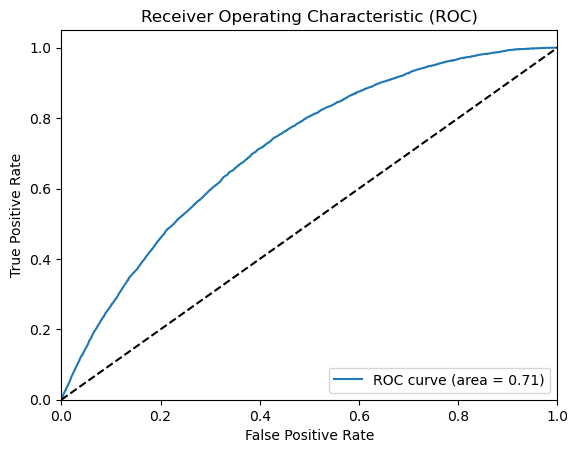

                                Feature  Importance
189  device_screen_resolution_2000x2000    2.917028
23      utm_source_fgymSoTvjKPEgaIJqsiH    2.462275
41            utm_medium_blogger_header    2.215678
145  utm_adcontent_PkybGvWbaqORmxjNunqZ    2.178922
322                 geo_country_Morocco    1.902271
128   utm_campaign_tnAqgCNATsNXcJwptHrh    1.804505
157  utm_adcontent_eOWmIGTKVDPewucDtZXG    1.721758
296                 geo_country_Ireland    1.692964
166  utm_adcontent_xhoenQgDQsgfEPYNPwKO    1.607552
51                     utm_medium_other    1.532293


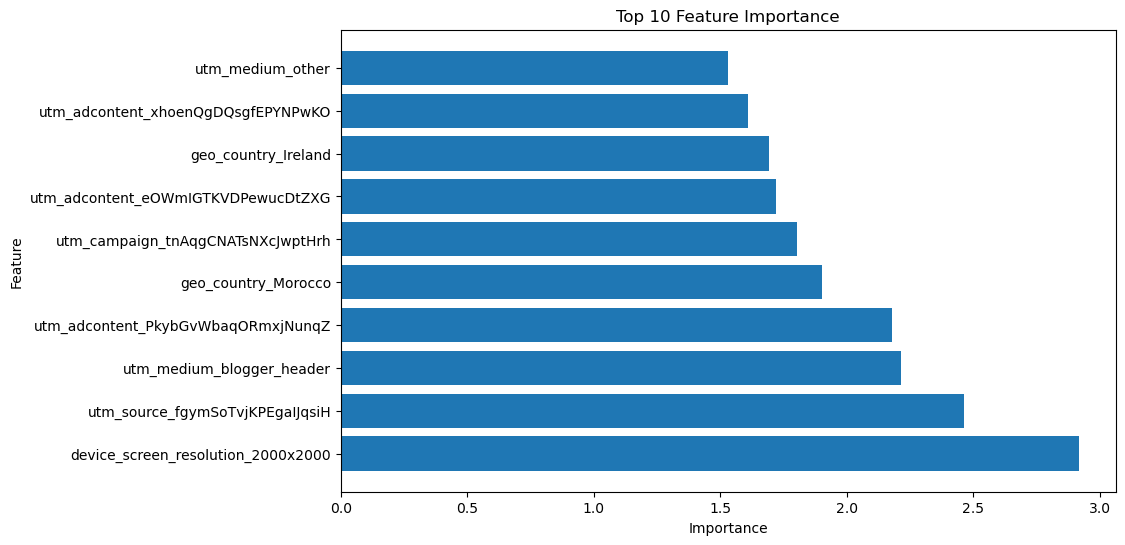

In [96]:
# Построение графика ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Определение важных признаков
best_log_reg = log_reg.best_estimator_

feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Importance': np.abs(best_log_reg_model.coef_[0])  
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Выбор 10 наиболее важных признаков
top_10_features = feature_importance.head(10)
print(top_10_features)

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()

### LightGBM 

In [97]:

lgb_params = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'class_weight': ['balanced']
}

lgb_model = lgb.LGBMClassifier(random_state=42)

lgb = GridSearchCV(estimator=lgb_model, param_grid=lgb_params, scoring='roc_auc', cv=4, verbose=1, n_jobs=-1)

lgb.fit(x_train, y_train)


Fitting 4 folds for each of 54 candidates, totalling 216 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17109, number of negative: 271775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 288884, number of used features: 306
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


GridSearchCV(cv=4, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'class_weight': ['balanced'],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 50, 100]},
             scoring='roc_auc', verbose=1)

In [98]:
best_lgb_model = lgb.best_estimator_

# Предсказание вероятностей на тестовом наборе данных
y_prob = best_lgb_model.predict_proba(x_test)[:, 1]

# Вычисление ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC: {roc_auc}')



ROC AUC: 0.7187479748291746


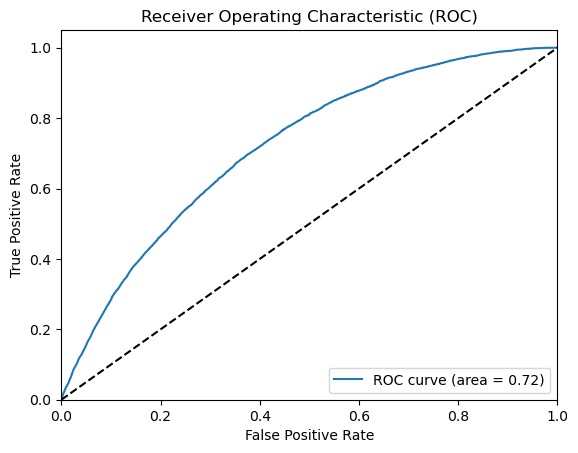

                            Feature  Importance
347              geo_country_Russia         106
179              device_brand_other          94
221  device_screen_resolution_other          93
222           device_browser_Chrome          90
176            device_brand_Samsung          86
226           device_browser_Safari          75
171             device_brand_Huawei          75
229        device_browser_YaBrowser          70
225            device_browser_Opera          69
180            device_brand_unknown          67


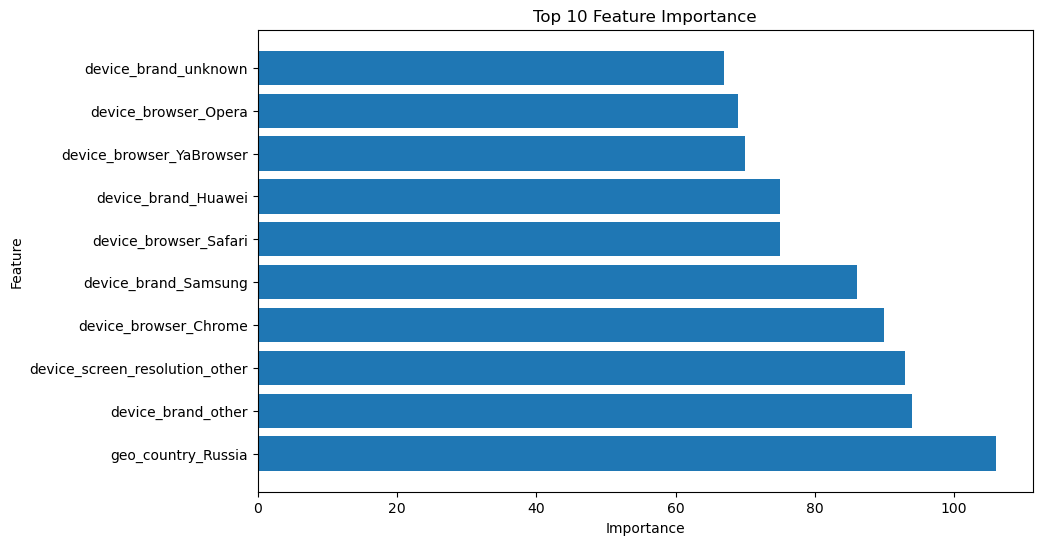

In [99]:
# Построение графика ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Определение важных признаков
feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Importance': best_lgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Выбор 10 наиболее важных признаков
top_10_features = feature_importance.head(10)
print(top_10_features)

# Построение гистограммы важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()

### CatBoost

In [100]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
# Рассчитываем веса классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Определение параметров для GridSearchCV
catboost_params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200, 300],
    'class_weights': [class_weight_dict]  # Передаем рассчитанные веса классов
}

catboost_model = CatBoostClassifier(random_state=42, verbose=0)

catboost = GridSearchCV(estimator=catboost_model, param_grid=catboost_params, scoring='roc_auc', cv=4, verbose=1, n_jobs=-1)

catboost.fit(x_train, y_train)


Fitting 4 folds for each of 27 candidates, totalling 108 fits


c:\Users\79292\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\79292\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\79292\anaconda3\Lib\site-packages\catboost\core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\79292\anaconda3\Lib\site-packages\catboost\core.py", line 2400, in

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001B55352A1D0>,
             n_jobs=-1,
             param_grid={'class_weights': [{0: 0.5314764051145249,
                                            1: 8.44245718627623}],
                         'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring='roc_auc', verbose=1)

In [101]:
best_catboost_model = catboost.best_estimator_

# Предсказание вероятностей на тестовом наборе данных
y_prob = best_catboost_model.predict_proba(x_test)[:, 1]

# Вычисление ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC: {roc_auc}')



ROC AUC: 0.7175370549937989


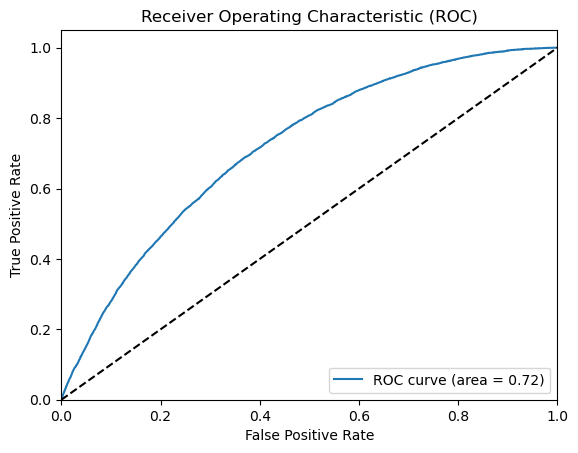

                                Feature  Importance
75    utm_campaign_LTuZkdKfxRGVceoWkVyg    6.602968
16      utm_source_ZpYIoDJMcFzVoPFsHGJL    6.178714
347                  geo_country_Russia    5.859321
221      device_screen_resolution_other    5.532641
139  utm_adcontent_JNHcPlZPxEMWDnRiyoBf    4.922087
389       utm_medium_added_is_organic_1    3.264439
222               device_browser_Chrome    2.711490
179                  device_brand_other    2.227736
10      utm_source_RmEBuqrriAfAVsLQQmhk    2.123196
23      utm_source_fgymSoTvjKPEgaIJqsiH    2.118811


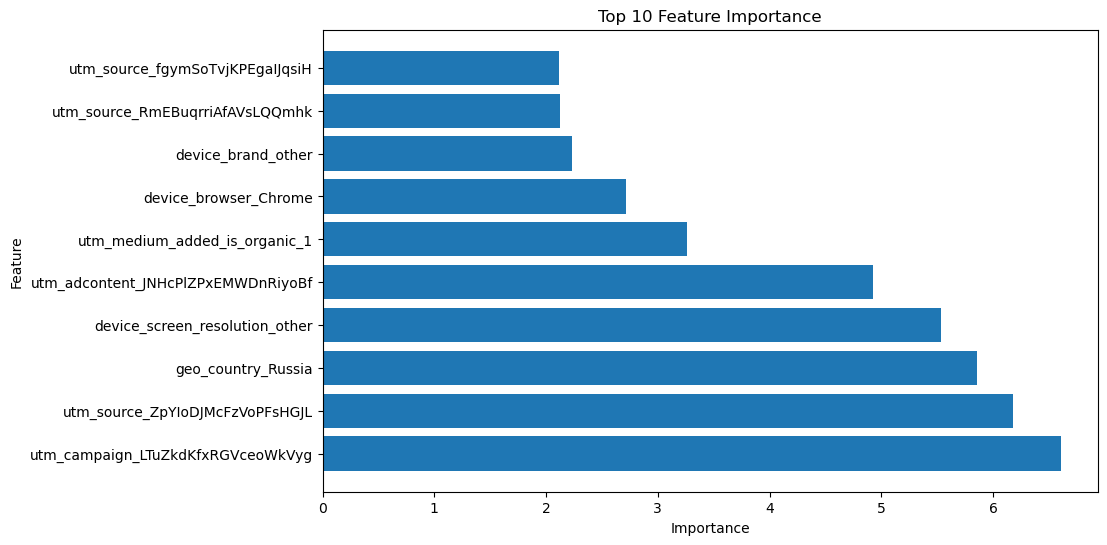

In [102]:
# Построение графика ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Определение важных признаков
feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Importance': best_catboost_model.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Выбор 10 наиболее важных признаков
top_10_features = feature_importance.head(10)
print(top_10_features)

# Построение гистограммы важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()

### RandomForestClassifier

In [103]:
from sklearn.ensemble import RandomForestClassifier
parameters_rf = {'min_samples_split': [2, 3, 4]}
rf_model = RandomForestClassifier(n_estimators=100,
                                max_features='sqrt',
                                min_samples_leaf=2,
                                bootstrap=False,
                                max_depth=100,
                                n_jobs=-1,
                                random_state=12,
                                class_weight='balanced')
clf_rf = GridSearchCV(rf_model, parameters_rf, cv=4, scoring='roc_auc', verbose=100)
clf_rf.fit(x_train, y_train)


Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START min_samples_split=2.........................................
[CV 1/4; 1/3] END ..........min_samples_split=2;, score=0.691 total time=  56.3s
[CV 2/4; 1/3] START min_samples_split=2.........................................
[CV 2/4; 1/3] END ..........min_samples_split=2;, score=0.693 total time=  54.9s
[CV 3/4; 1/3] START min_samples_split=2.........................................
[CV 3/4; 1/3] END ..........min_samples_split=2;, score=0.690 total time=  56.3s
[CV 4/4; 1/3] START min_samples_split=2.........................................
[CV 4/4; 1/3] END ..........min_samples_split=2;, score=0.691 total time=  55.7s
[CV 1/4; 2/3] START min_samples_split=3.........................................
[CV 1/4; 2/3] END ..........min_samples_split=3;, score=0.691 total time=  58.6s
[CV 2/4; 2/3] START min_samples_split=3.........................................
[CV 2/4; 2/3] END ..........min_samples_split=3;,

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              max_depth=100, min_samples_leaf=2,
                                              n_jobs=-1, random_state=12),
             param_grid={'min_samples_split': [2, 3, 4]}, scoring='roc_auc',
             verbose=100)

In [104]:
best_clf_rf_model = clf_rf.best_estimator_

# Предсказание вероятностей на тестовом наборе данных
y_prob = best_catboost_model.predict_proba(x_test)[:, 1]

# Вычисление ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC: {roc_auc}')



ROC AUC: 0.7175370549937989


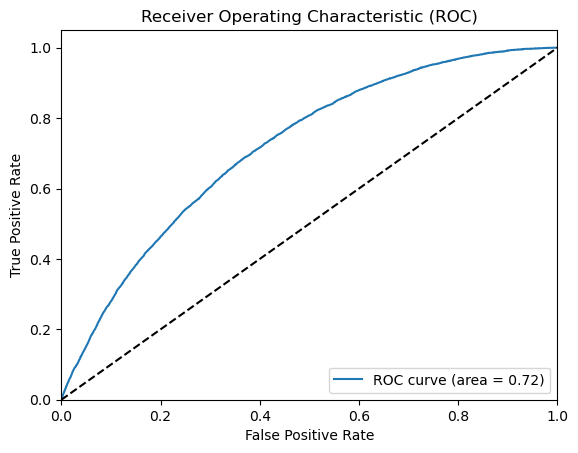

                                Feature  Importance
75    utm_campaign_LTuZkdKfxRGVceoWkVyg    0.055443
221      device_screen_resolution_other    0.044105
347                  geo_country_Russia    0.030718
389       utm_medium_added_is_organic_1    0.028264
139  utm_adcontent_JNHcPlZPxEMWDnRiyoBf    0.024021
222               device_browser_Chrome    0.022939
68    utm_campaign_FTjNLDyTrXaWYgZymFkV    0.022876
16      utm_source_ZpYIoDJMcFzVoPFsHGJL    0.022839
10      utm_source_RmEBuqrriAfAVsLQQmhk    0.020433
45                       utm_medium_cpc    0.019740


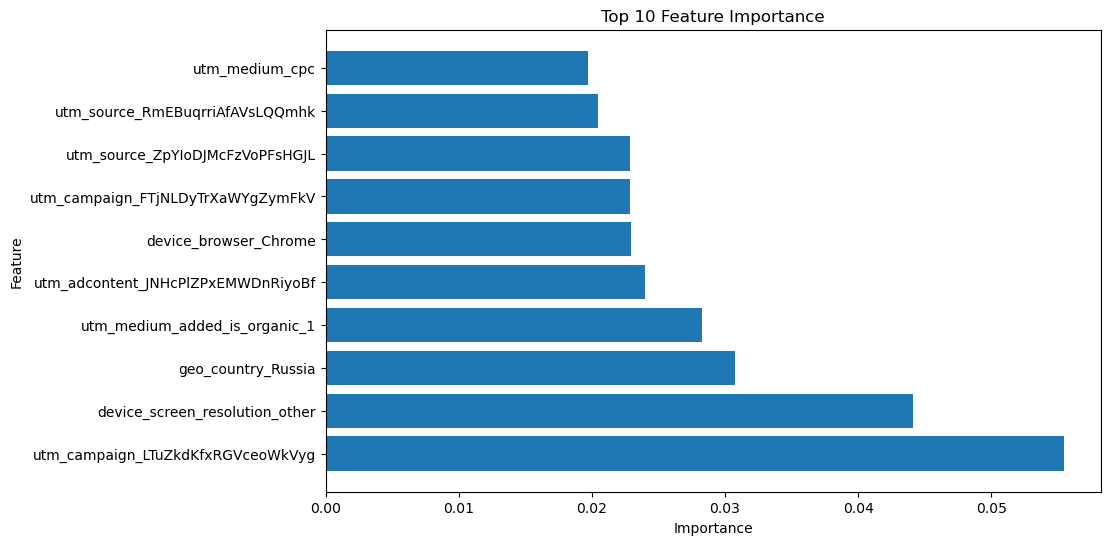

In [105]:
# Построение графика ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Определение важных признаков
feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Importance': best_clf_rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Выбор 10 наиболее важных признаков
top_10_features = feature_importance.head(10)
print(top_10_features)

# Построение гистограммы важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()

### MLPClassifier 

In [106]:
from sklearn.neural_network import MLPClassifier
parameters_mlp = {'hidden_layer_sizes': [(2, 2), (5, 2)]}
mlp_model = MLPClassifier(activation='identity',
                        solver='lbfgs',
                        alpha=0.0001,
                        tol=1e-3,
                        max_iter=1000,
                        random_state=12)
mlp = GridSearchCV(mlp_model, parameters_mlp, cv=4, scoring='roc_auc', verbose=100)
mlp.fit(x_train, y_train)




Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START hidden_layer_sizes=(2, 2)...................................
[CV 1/4; 1/2] END ....hidden_layer_sizes=(2, 2);, score=0.696 total time=  10.7s
[CV 2/4; 1/2] START hidden_layer_sizes=(2, 2)...................................
[CV 2/4; 1/2] END ....hidden_layer_sizes=(2, 2);, score=0.694 total time=  10.3s
[CV 3/4; 1/2] START hidden_layer_sizes=(2, 2)...................................
[CV 3/4; 1/2] END ....hidden_layer_sizes=(2, 2);, score=0.696 total time=  11.5s
[CV 4/4; 1/2] START hidden_layer_sizes=(2, 2)...................................
[CV 4/4; 1/2] END ....hidden_layer_sizes=(2, 2);, score=0.700 total time=  13.3s
[CV 1/4; 2/2] START hidden_layer_sizes=(5, 2)...................................
[CV 1/4; 2/2] END ....hidden_layer_sizes=(5, 2);, score=0.689 total time=   8.4s
[CV 2/4; 2/2] START hidden_layer_sizes=(5, 2)...................................
[CV 2/4; 2/2] END ....hidden_layer_sizes=(5, 2);, 

GridSearchCV(cv=4,
             estimator=MLPClassifier(activation='identity', max_iter=1000,
                                     random_state=12, solver='lbfgs',
                                     tol=0.001),
             param_grid={'hidden_layer_sizes': [(2, 2), (5, 2)]},
             scoring='roc_auc', verbose=100)

In [107]:
# Получение лучшей модели
best_mlp_model = mlp.best_estimator_

# Предсказание вероятностей на тестовом наборе данных
y_prob = best_mlp_model.predict_proba(x_test)[:, 1]

# Вычисление ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.7007296084513297


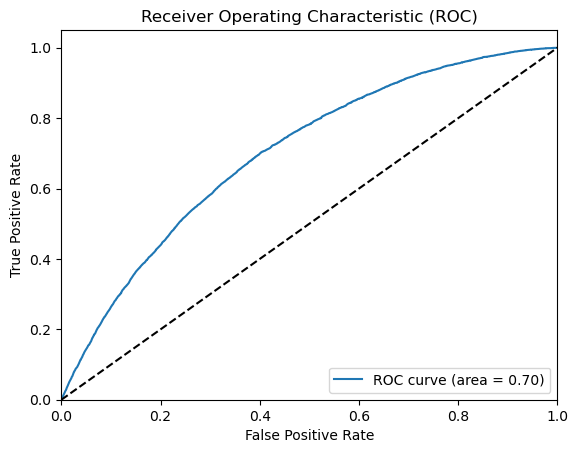

                               Feature  Importance
75   utm_campaign_LTuZkdKfxRGVceoWkVyg    1.022417
347                 geo_country_Russia    0.936241
221     device_screen_resolution_other    0.756989
74   utm_campaign_LEoPHuyFvzoNfnzGgfcd    0.590954
45                      utm_medium_cpc    0.546667
179                 device_brand_other    0.543883
110  utm_campaign_gecBYcKZCPMcVYdSSzKP    0.526532
10     utm_source_RmEBuqrriAfAVsLQQmhk    0.522664
9      utm_source_QxAxdyPLuQMEcrdZWdWb    0.513538
226              device_browser_Safari    0.487144


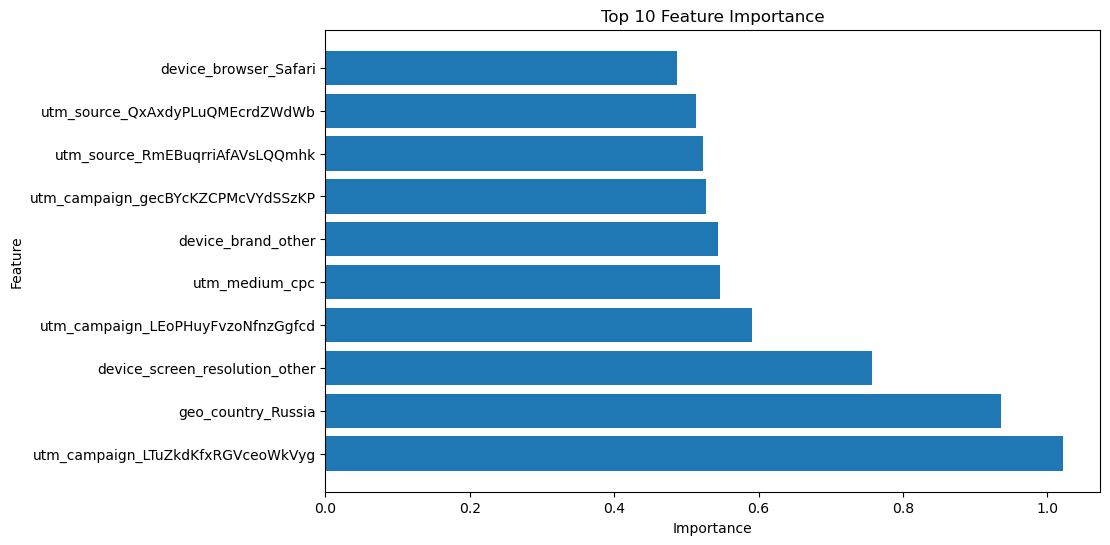

In [108]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
# Получение весов связей
weights = best_mlp_model.coefs_

# Анализ весов связей
feature_importance = np.abs(weights[0]).mean(axis=1)

# Создание DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Выбор 10 наиболее важных признаков
top_10_features = feature_importance_df.head(10)
print(top_10_features)

# Построение гистограммы важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()

# Выбор лучшей модели

In [109]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# Список моделей и их имен
models = [best_log_reg_model, best_lgb_model, best_catboost_model,best_clf_rf_model,best_mlp_model]
model_names = ['Logistic Regression', 'LightGBM', 'CatBoost','RandomForestClassifier','MLPClassifier']

# Словари для хранения результатов
results_roc_auc = {}
results_precision = {}
results_recall = {}

# Оценка каждой модели
for model, name in zip(models, model_names):
    y_prob = model.predict_proba(x_test)[:, 1]
    y_pred = model.predict(x_test)
    
    roc_auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results_roc_auc[name] = roc_auc
    results_precision[name] = precision
    results_recall[name] = recall

# Вывод результатов
for name in model_names:
    print(f'{name}: ROC AUC = {results_roc_auc[name]:.4f}, Precision = {results_precision[name]:.4f}, Recall = {results_recall[name]:.4f}')

# Выбор лучшей модели по ROC AUC
best_model_name = max(results_roc_auc, key=results_roc_auc.get)
best_model = models[model_names.index(best_model_name)]
print(f'Лучшая модель по ROC AUC: {best_model_name} с ROC AUC = {results_roc_auc[best_model_name]:.4f}')

Logistic Regression: ROC AUC = 0.7131, Precision = 0.1008, Recall = 0.7151
LightGBM: ROC AUC = 0.7187, Precision = 0.1034, Recall = 0.7055
CatBoost: ROC AUC = 0.7175, Precision = 0.1022, Recall = 0.7096
RandomForestClassifier: ROC AUC = 0.6988, Precision = 0.1010, Recall = 0.6500
MLPClassifier: ROC AUC = 0.7007, Precision = 0.0000, Recall = 0.0000
Лучшая модель по ROC AUC: LightGBM с ROC AUC = 0.7187


c:\Users\79292\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Result

In [110]:
best_lgb_model.fit(x,y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 24441, number of negative: 388251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 412692, number of used features: 314
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', num_leaves=50, random_state=42)